In [2]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

# Список литературы

1. "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", Géron, A., 2017, *O'Reilly Media*
2. "An Introduction to Statistical Learning: With Applications in R.", Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani, 2014, *Springer Publishing Company, Incorporated*
3. [Sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix)
4. "Scaling to Very Very Large Corpora for Natural Language Disambiguation", Michele Banko and Eric Brill, 2001, *Microsoft Research*

# SVM

Support Vector Machine (SVM), он же метод опорных векторов, одна из самых мощных и гибких ML моделей. SVM поддерживает линейную и нелинейную классификацию, регрессию и даже поиск выбросов. Лучше всего SVM подходит для классификации сложных датасетов среднего или малого размера.

## Теория

В случае с двухмерными линейно разделяемыми данными, SVM создает границу принятия решения так, чтобы экземпляры двух классов были максимально удалены от этой границы. 

In [3]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[0, 5.5, 0, 2]

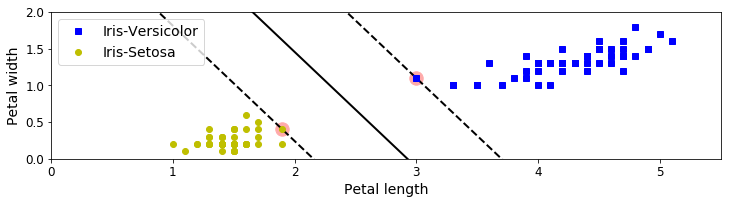

In [4]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(12,2.7))
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

Можно думать об SVM как о классификаторе, который пытается построить наиболее широкую *улицу* между данными. Точки, находящиеся на границе улицы, называются опорными векторами (support vector). 

Математика под капотом:
$$\hat{y} = 
\begin{cases}
    0\ if\ \mathbf{w}^T \cdot \mathbf{x} + b < 0,\\
    1\ if\ \mathbf{w}^T \cdot \mathbf{x} + b \ge 0\\
\end{cases}
$$

Цель - найти оптимальный $\mathbf{w}$ и $b$.

SVM чувствителен к масштабированию данных:

[-2, 2, -2, 2]

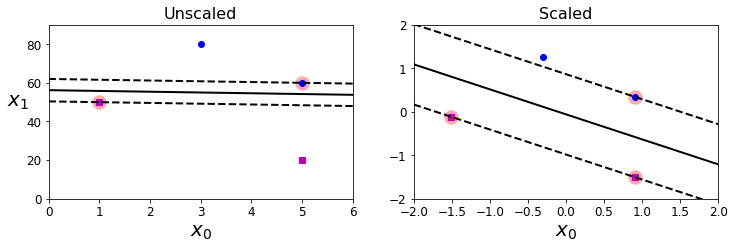

In [5]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

## Hard & soft margin classification

Рассмотренные до этого примеры - это hard margin classification. При hard margin классификации экземпляры одного класса находятся по одну сторону от разделяющей поверхности. Если в данных есть выбросы, hard margin classification не всегда находит оптимальную границу разделения (а иногда совсем ее не находит).

[0, 5.5, 0, 2]

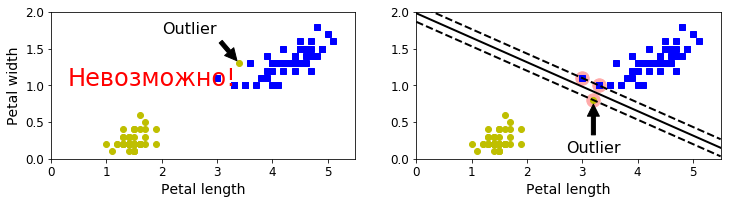

In [6]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Невозможно!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

В таких случаях используется soft margin classification. Данный способ классификации допускает нарушение границы разделения некоторым количеством экземпляров. В sklearn допустимое нарушение регулируется параметром $C$.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline((
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ))
scaled_svm_clf2 = Pipeline((
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ))

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(steps=(('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))))

In [8]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

[4, 6, 0.8, 2.8]

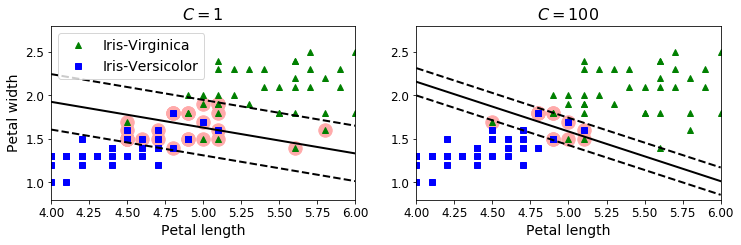

In [9]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

## Нелинейная классификация

В некоторых случаях данные не могут быть разделены линейно:

[-4.5, 4.5, -0.2, 0.2]

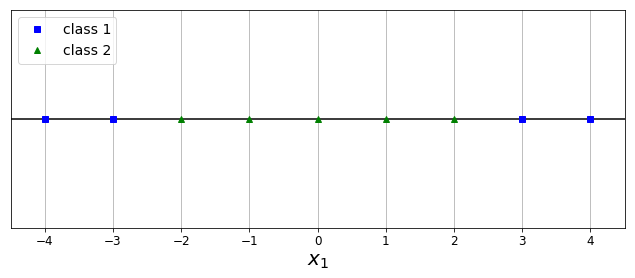

In [10]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs", label="class 1")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^", label="class 2")
plt.legend(loc="upper left", fontsize=14)
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

Но, например, если мы добавим еще одну фичу $x_2 = {x_1}^2$, то данные станут линейно разделимыми:

[-4.5, 4.5, -1, 17]

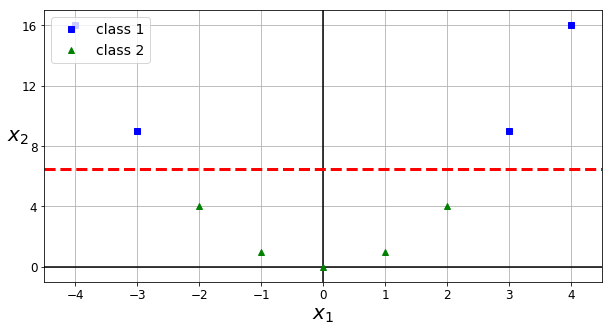

In [11]:
X2D = np.c_[X1D, X1D**2]

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs", label="class 1")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^", label="class 2")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

Еще один пример линейно неразделимых данных:

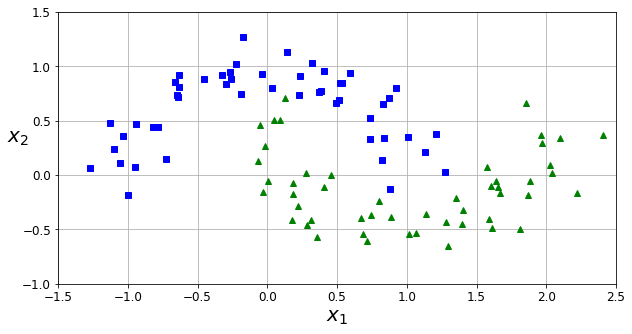

In [12]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

Как и раньше, данную задачу классификации можно решить созданием полиномиальных фич:

In [13]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline((
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ))

polynomial_svm_clf.fit(X, y)

Pipeline(steps=(('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))))

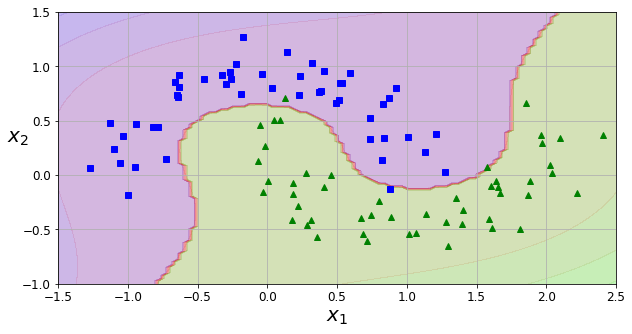

In [14]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

Но проблема в том, что `PolynomialFeatures(degree=3)` увеличивает количество фич и, как следствие, объем занимаемой памяти.

In [15]:
print(X.shape)
print(PolynomialFeatures(degree=3).fit_transform(X).shape)

(100, 2)
(100, 10)


Чтобы избежать увеличения объема памяти, используют kernalization (ядерное преобразование).

## Kernel trick

Предположим, мы хотим применить к данным полиномиальное преобразование второй степени, после чего воспользоваться SVM классификатором. Функция отображения в полином второй степени выглядит так:
$$\phi(\mathbf{x}) = \phi(\left(\begin{array}{c}x_1\\x_2\end{array}\right)) = \left(\begin{array}{c}{x_1}^2\\\sqrt{2}x_1x_2\\{x_2}^2\end{array}\right)$$

Давайте теперь посмотрим, что произойдет с двухмерными векторами $\mathbf{a}$ и $\mathbf{b}$, если мы применим к ним функцию отображения, а затем найдем dot-product преобразованных векторов.
$$\phi(\mathbf{a})^T \cdot \phi(\mathbf{b}) = \left(\begin{array}{c}{a_1}^2\\\sqrt{2}a_1a_2\\{a_2}^2\end{array}\right)^T \cdot \left(\begin{array}{c}{b_1}^2\\\sqrt{2}b_1b_2\\{b_2}^2\end{array}\right) = {a_1}^2 {b_1}^2 + 2a_1b_1a_2b_2 + {a_2}^2 {b_2}^2 = (a_1b_1 + a_2b_2)^2 = (\left(\begin{array}{c}a_1\\a_2\end{array}\right)^T \cdot \left(\begin{array}{c}b_1\\b_2\end{array}\right))^2 = (\mathbf{a}^T \cdot \mathbf{b})^2$$

Т.е. $\phi(\mathbf{a})^T \cdot \phi(\mathbf{b}) = (\mathbf{a}^T \cdot \mathbf{b})^2$ и не нужно создавать никаких дополнитильных фич.

Поиск решения в SVM - это constrained optimization problem, которую в некоторых случаях (SVM как раз тот случай) можно решить через двойственную задачу. В случае с SVM она выглядит так:
$$\operatorname*{minimize}_\alpha \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)}\alpha^{(j)} t^{(i)}t^{(j)} \mathbf{x}^{(i)^T}\mathbf{x}^{(j)} - \sum_{i=1}^m \alpha^{(i)}$$
где
$$\alpha^{(i)} \ge 0\ для\ i=1, 2, \dots, m$$

Найдя $\hat{\alpha}$, мы можем выразить через него $\mathbf{w}$ и $b$:
$$
\hat{\mathbf{w}} = \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \mathbf{x}^{(i)} \\
\hat{b} = \frac{1}{n_S} \sum_{i=1}^m (1 - t^{(i)} (\hat{\mathbf{w}}^T \mathbf{x}^{(i)})) \\
\hat{\alpha}^{(i)} > 0
$$

Теперь, чтобы предсказать класс для экземпляра $\mathbf{x}^{(n)}$, достаточно воспользоваться полученными равенствами и kernel trick-ом:

$$
h_{\hat{\mathbf{w}}, \hat{b}}(\phi(\mathbf{x}^{(n)})) = \\
\hat{\mathbf{w}}^T \cdot \phi(\mathbf{x}^{(n)}) + \hat{b} = \\ (\sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \phi(\mathbf{x}^{(i)}))^T \cdot \phi(\mathbf{x}^{(n)}) + \hat{b} = \\  \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} (\phi(\mathbf{x}^{(i)})^T \cdot \phi(\mathbf{x}^{(n)})) + \hat{b} = \\ \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} K(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}) + \hat{b}
$$

где $K(\mathbf{a}, \mathbf{b})$ - ядерная функция.

## Существующие ядра

* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = exp(-\gamma\|\mathbf{a} - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

## Пример

In [16]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
))
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ))
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=(('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape=None, degree=10, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))))

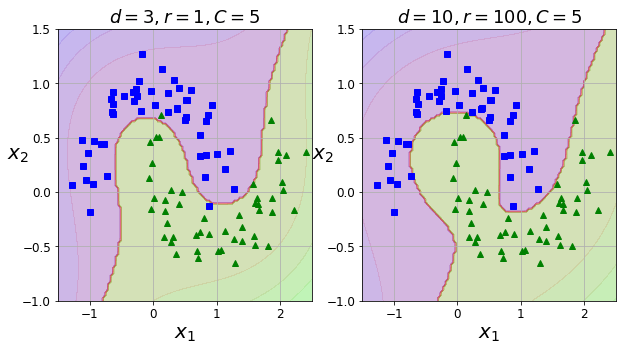

In [17]:
plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)

#### Подробнее в [1], глава 5

# Dimensionality reduction

Большинство ML задач предполагает работу с большим количеством фич. Большое количество фич не только замедляет работу алгоритмов, но и усложняет процесс поиска решения (curse of dimensionality). 

Например, среднее расстояние между двумя случайно выбранными точками в квадрате с длиной стороны равной 1 равно 0.52. В то же время в 1,000,000-размерном гиперкубе, с длиной стороны 1, среднее расстояние будет равно 408.52. Т.е. объекты в многомерном пространстве находятся далеко друг от друга, что требует от ML модели сильной экстраполяции и, как следствие, уменьшается точность.

В целом dimensionality reduction призван лишь уменьшить размерность данных, чтобы ускорить процесс обучения. Побочными эффектами (!) могут стать уменьшение шумов и улучшение обобщающих свойств модели.

Часто для визуализации данных используют уменьшение пространства до 2D и 3D.

Два основных способа уменьшения пространства: projection и manifold learning.

### Projection

In [18]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

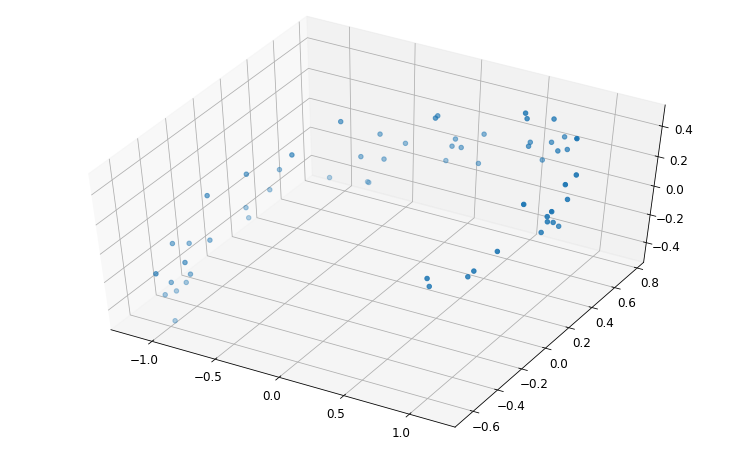

In [19]:
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig, azim=300, elev=50)
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

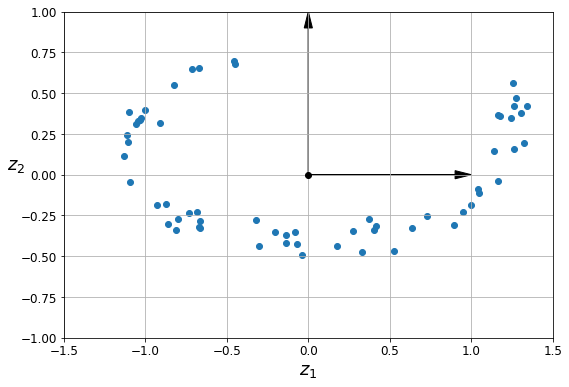

In [23]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(X2D[:, 0], X2D[:, 1])
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.5, -1, 1])
ax.grid(True)

Т.е. мы проецируем исходные данные в новое пространство меньшего размера, пытаясь сохранить как можно больше исходного variance.

### Manifold learning

В некоторых случаях обычного проецирования недостаточно.

In [24]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

(-12, 15)

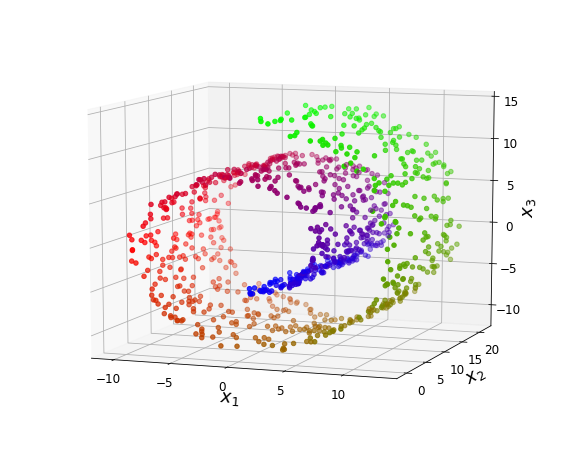

In [25]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.brg)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

Manifold learning пытается найти оптимальный manifold, описывающий исходные данные.

In [26]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

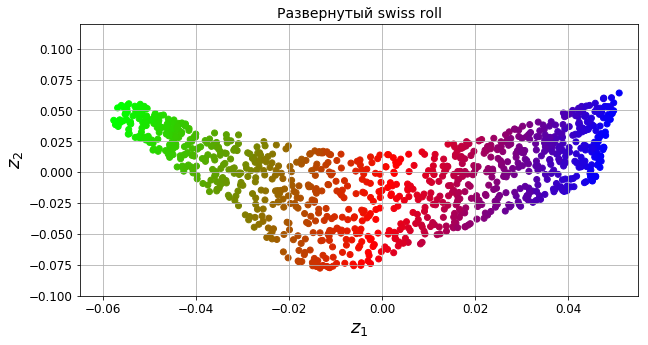

In [27]:
plt.title("Развернутый swiss roll", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.brg)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

`LocallyLinearEmbedding` изучает линейные связи между точками в исходном пространстве, после чего пытается перейти в меньшее пространство, сохранив при этом линейные связи.

## PCA

Самый популярный способ проекции данных. PCA итеративно проецирует исходные данные на компоненты (оси). Каждая новая компонента должна быть ортогональна предыдущей и описывать максимальное количество остаточного variance.

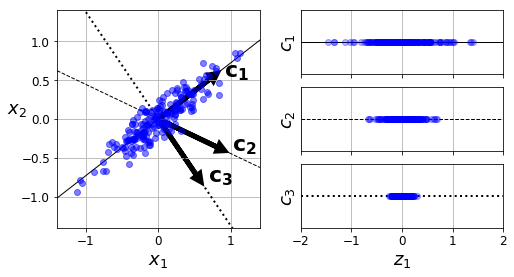

In [28]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])

plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u2[0], u2[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')

plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u2[0] + 0.1, u2[1], r"$\mathbf{c_2}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_3}$", fontsize=22)

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.ylabel("$c_1$", fontsize=18)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.ylabel("$c_2$", fontsize=18)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.ylabel("$c_3$", fontsize=18)
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

На картинке выше изображены три компоненты и variance, описанный каждой из них. 

Для подбора оптимального количества компонент используют метод "локтя" (elbow method). Метод итеративно увеличивает количество компонент и на каждой итерации вычисляет процент variance исходных данных, описанный всеми компонентами, добавленными до этой итерации. Если принять количество компонент за ось X, а процент описанного variance за Y, то получится изображение похожее на локоть. Оно демонстрирует оптимальное количество компонент для объяснения исходных данных.

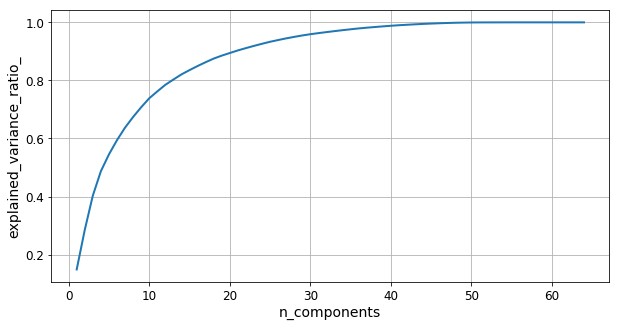

In [29]:
digits = datasets.load_digits()
X_digits = digits.data
pca = PCA().fit(X_digits)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

## Kernel PCA

Мы упоминали ядерное преобразование при работе с SVM. Аналогичную уловку можно применить и в PCA. Такое преобразование позволяет  осуществить сложную нелинейную проекцию при уменьшении пространства.

In [30]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

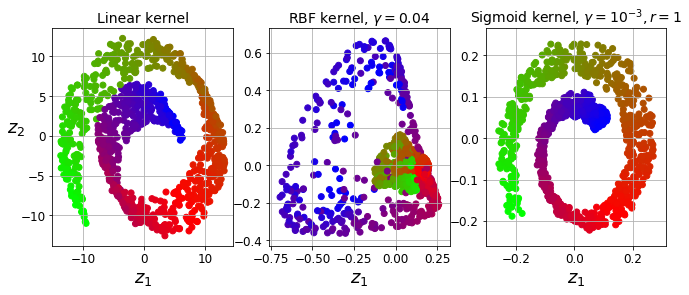

In [31]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.brg)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

## MDS, Isomap and t-SNE

In [32]:
from sklearn.manifold import MDS, Isomap, TSNE

# уменьшает размерность, пытаясь сохранить расстояние между объектами
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

# создает граф, соединяя объекты с их ближайшими соседями
# уменьшает размерность, пытаясь сохранить геодезическое расстояние 
# (количество узлов в кратчайшем пути между двумя исходными вершинами графа)
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

# уменьшает размерность, пытаясь сохранить близкие в исходном пространстве объекты ближе друг к другу, 
# а далекие подальше друг от друга (часто используется для визуализации кластеров)
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

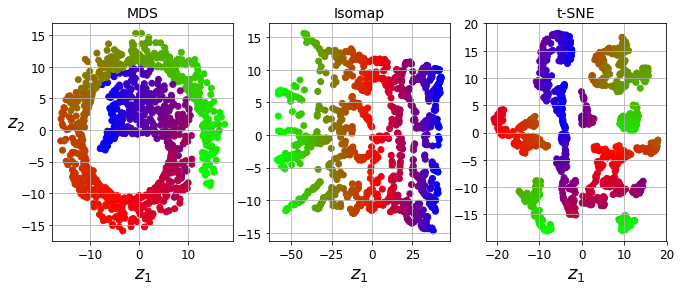

In [33]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.brg)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#### Подробнее в [1], глава 8

А здесь можно поиграть с визуализацией: http://projector.tensorflow.org/